# Le Mécanisme Exponentiel appliqué au quantile

## Installation des packages nécessaires

In [ ]:
%pip install opendp
%pip install 'opendp[polars]'

## Les données suivant une distribution normale

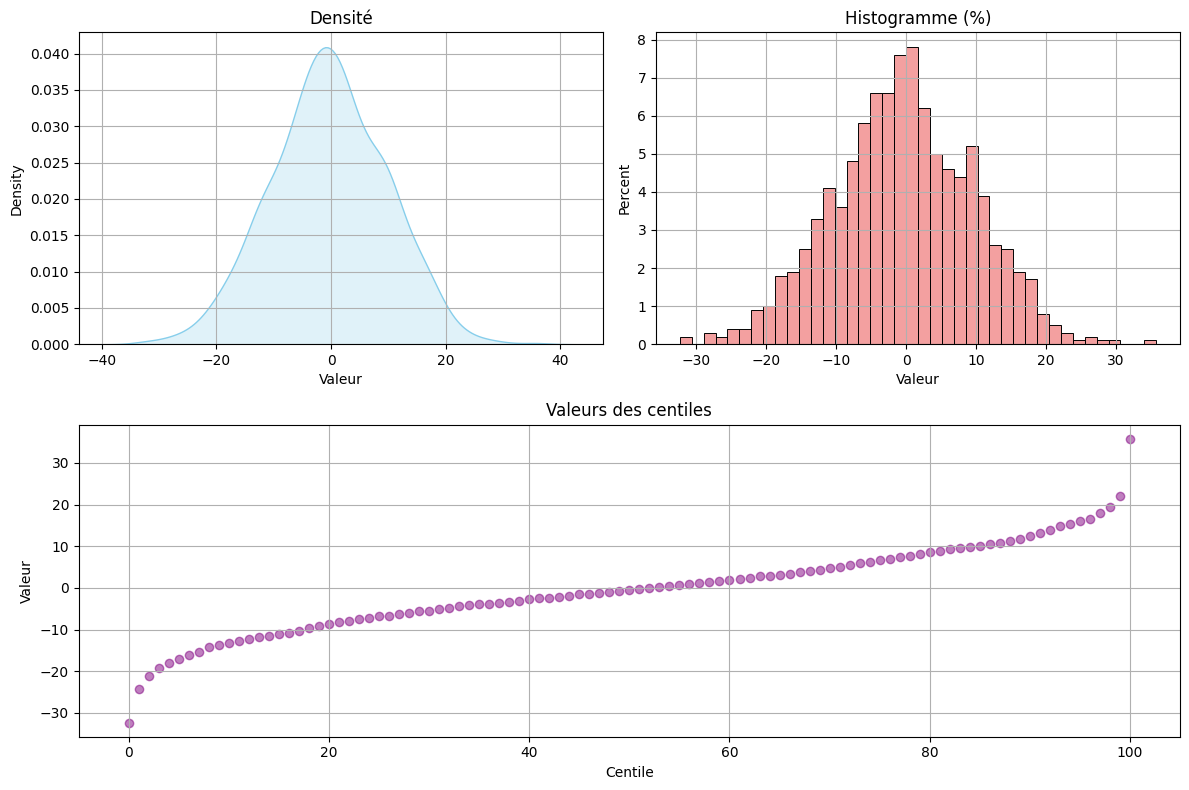

,data
count,1000.000000
mean,-0.395641
std,10.012883
min,-32.310550
25%,-6.845566
50%,-0.411856
75%,6.688657
max,35.715792


In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(123) 

data = np.random.normal(scale=10, size=1000)

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 lignes, 2 colonnes

# Graphique en haut à gauche
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data, fill=True, color='skyblue', ax=ax1)
ax1.set_title("Densité")
ax1.set_xlabel("Valeur")
ax1.grid(True)

# Graphique en haut à droite
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data, stat="percent", bins=40, color='lightcoral', ax=ax2)
ax2.set_title("Histogramme (%)")
ax2.set_xlabel("Valeur")
ax2.grid(True)

# Graphique en bas sur toute la largeur
ax3 = fig.add_subplot(gs[1, :])

# Calcul des centiles (0 à 100)
centiles = np.arange(101)
valeurs = np.percentile(data, centiles)

ax3.scatter(centiles, valeurs, color="purple", alpha=0.5)
ax3.set_title("Valeurs des centiles")
ax3.set_xlabel("Centile")
ax3.set_ylabel("Valeur")
ax3.grid(True)

plt.tight_layout()
plt.show()

df = pd.DataFrame({"data": data})
df.describe()

## Chaîne représentant le processus de 3 façons différentes

In [ ]:
import opendp.prelude as dp
import numpy as np
import polars as pl

dp.enable_features("contrib", "honest-but-curious")

np.random.seed(123)  # N'affecte pas l'aléa d'OpenDP

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()

data = np.random.normal(scale=10, size=1000)
candidats = np.linspace(-50, 50, 101).tolist()
alpha = 0.7
scale = 1

# Méthode 1 (base)

quantile = space >> dp.m.then_private_quantile(
    candidates=candidats,
    alpha=alpha,
    scale=scale
)

sensibilite = quantile.map(d_in=1)

# Méthode 2 (déstructuré)

quantile = (
    space
    # 1. transformation: calcul du score associé à chaque candidat
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    # 2. measurement: tire l'index score le plus petit après ajout du bruit
    >> dp.m.then_report_noisy_max_gumbel(scale=scale, optimize="min")
    # 3. postprocessor: renvoie le candidat à partir de l'index
    >> (lambda i: candidats[i])
)

# Méthode 3 (polars)

df = pl.DataFrame({
    "valeurs": data
})

context = dp.Context.compositor(
    data=df.lazy(),
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=0.1),
    split_evenly_over=1,
    margins=[
        dp.polars.Margin(
            max_partition_length=1000
        ),
    ],
) 

query_quantile = (
    context.query()
    .select(
        pl.col.valeurs
        .fill_null(0)
        .dp.quantile(0.75, candidats)
    )
)  

query_quantile.release().collect().item()

print(f"La valeur du quantile d'ordre {alpha} respectant la DP est", quantile(data))
print(f"La senbsibilité de tout le processus est", quantile.map(d_in=1))

La valeur du quantile d'ordre 0.7 respectant la DP est 5.0
La senbsibilité de tout le processus est 14000.0


## La fonction de score

$\textrm{score}(x, c, \alpha_{num}, \alpha_{den}) = -|\alpha_{den} \cdot \#(x < c) - \alpha_{num} \cdot (|x| - \#(x = c))|$

Sensibilité estimé : 1


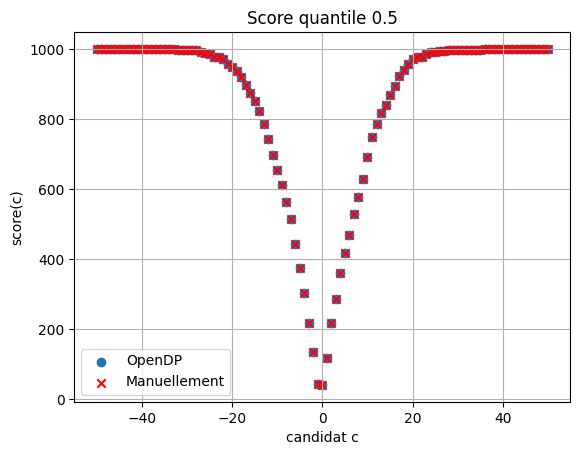

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import opendp.prelude as dp

dp.enable_features("contrib")

np.random.seed(123)
data = np.random.normal(scale=10, size=1000)
candidats = np.linspace(-50, 50, 101)
alpha = 0.5

quantile_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidats, 
    alpha=alpha)

scores = quantile_scores(data)

def manual_quantile_score(data, candidats, alpha, et_si=False):
    if alpha == 0:
        alpha_num, alpha_denum = 0, 1
    elif alpha == 0.25:
        alpha_num, alpha_denum = 1, 4
    elif alpha == 0.5:
        alpha_num, alpha_denum = 1, 2
    elif alpha == 0.75:
        alpha_num, alpha_denum = 3, 4
    elif alpha == 1:
        alpha_num, alpha_denum = 1, 1
    else:
        alpha_num = int(np.floor(alpha * 10_000))
        alpha_denum = 10_000

    if et_si == True:
        alpha_num = int(np.floor(alpha * 10_000))
        alpha_denum = 10_000

    scores = []
    for c in candidats:
        n_less = np.sum(data < c)
        n_equal = np.sum(data == c)
        score = alpha_denum * n_less - alpha_num * (len(data) - n_equal)
        scores.append(abs(score))

    print("Sensibilité estimé :", max(alpha_num, alpha_denum - alpha_num))
    return np.array(scores), max(alpha_num, alpha_denum - alpha_num)

scores_m, _ = manual_quantile_score(data, candidats, alpha)

plt.scatter(candidats, scores, marker='o', label="OpenDP")
plt.scatter(candidats, scores_m, color = "red", marker='x', label="Manuellement")
plt.title(f"Score quantile {alpha}")
plt.xlabel("candidat c")
plt.ylabel("score(c)")
plt.legend()
plt.grid(True)
plt.show()


## Comparaison résultat si score multiplié par alpha_denom = 10_000

Sensibilité estimé : 3
Sensibilité estimé : 7500


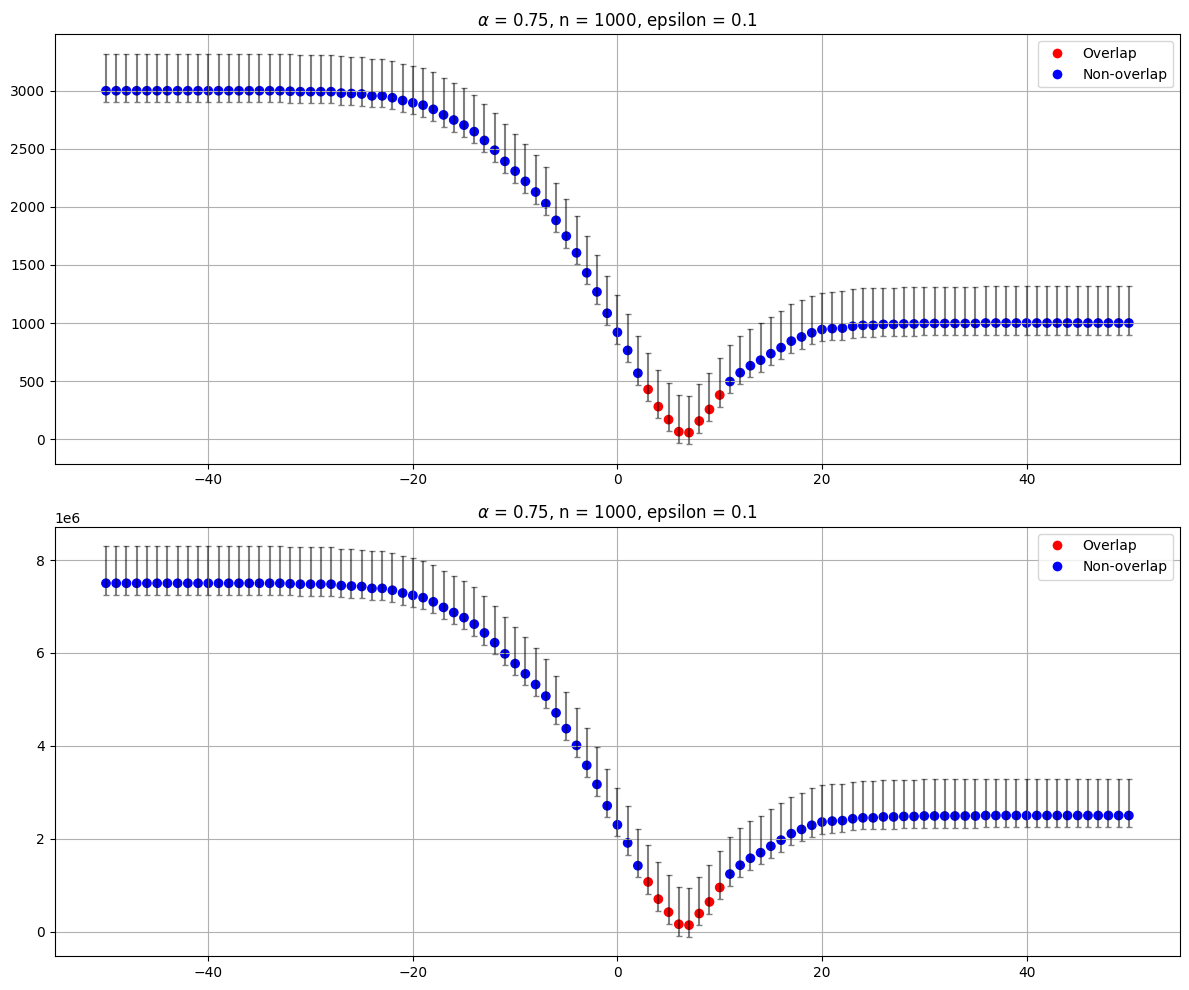

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
alpha = 0.75
list_sensibilite = [3, 7500]
epsilon = 0.1

fig, axs = plt.subplots(2, figsize=(12, 10))

for i, ax in enumerate(axs.flat):

    scores, _ = manual_quantile_score(data, candidats, alpha=alpha, et_si=[False, True][i])
        
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * list_sensibilite[i] / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {alpha}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

## Intervalle de confiance

Sensibilité estimé : 10000
Sensibilité estimé : 8000
Sensibilité estimé : 5000
Sensibilité estimé : 7500


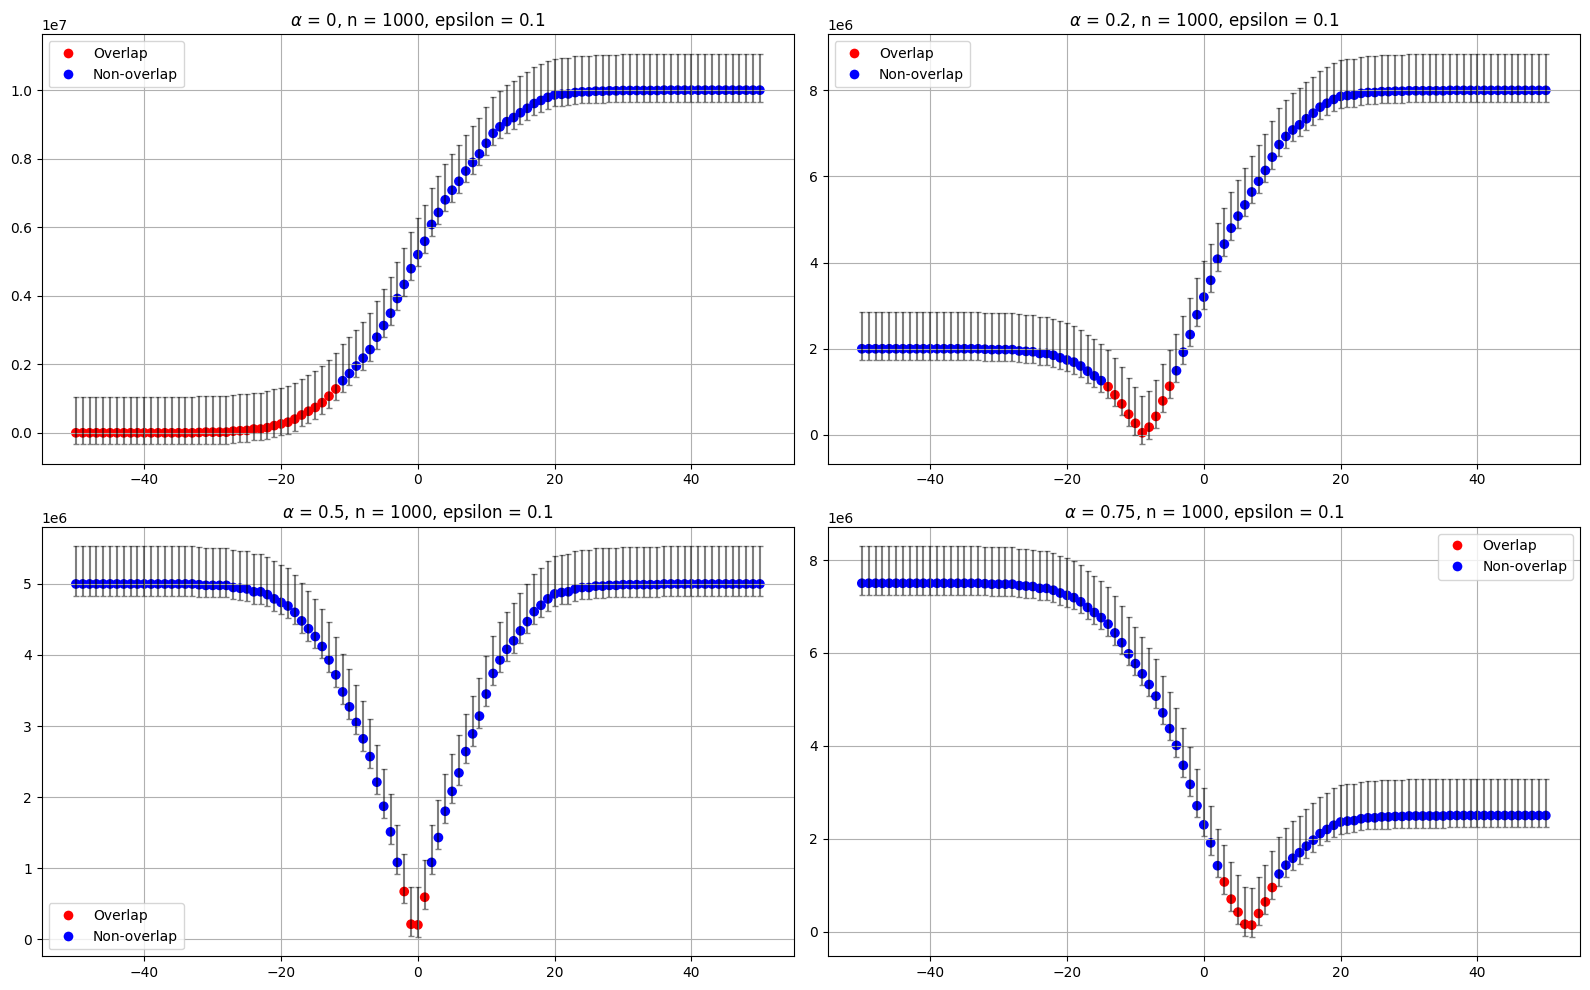

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
list_alpha = [0, 0.2, 0.5, 0.75]
epsilon = 0.1

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

## Les résultats simulés

### Polars :D

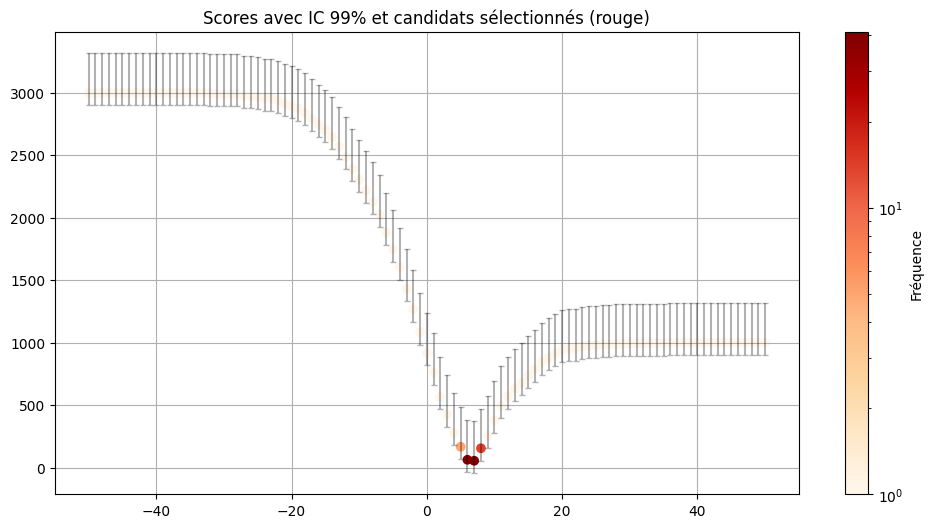

Counter({7.0: 41, 6.0: 38, 8.0: 14, 5.0: 5, 9.0: 1, 4.0: 1})
6
shape: (1, 4)
┌─────────┬───────────────┬──────────────┬───────┐
│ column  ┆ aggregate     ┆ distribution ┆ scale │
│ ---     ┆ ---           ┆ ---          ┆ ---   │
│ str     ┆ str           ┆ str          ┆ f64   │
╞═════════╪═══════════════╪══════════════╪═══════╡
│ valeurs ┆ 0.75-Quantile ┆ GumbelMin    ┆ 60.0  │
└─────────┴───────────────┴──────────────┴───────┘


In [ ]:
import polars as pl
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r
import opendp.prelude as dp
from matplotlib.colors import LogNorm
from matplotlib import cm, colors as mcolors
dp.enable_features("contrib")
np.random.seed(123)

n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
alpha = 0.75
epsilon = 0.1

df = pl.DataFrame({
    "valeurs": data
})

list_values = []
N = 100

for i in range(N):
    context = dp.Context.compositor(
        data=df.lazy(),
        privacy_unit=dp.unit_of(contributions=1),
        privacy_loss=dp.loss_of(epsilon=epsilon),
        split_evenly_over=1,
        margins=[
            dp.polars.Margin(
                max_partition_length=1000
            ),
        ],
    ) 
    query_multi_quantiles = (
        context.query()
        .select(
            pl.col.valeurs
            .fill_null(0)
            .dp.quantile(alpha, candidats)
        )
    )  
    list_values.append(query_multi_quantiles.release().collect().item())


quantile_scores = dp.t.make_quantile_score_candidats(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidats, 
    alpha=alpha)

scores = quantile_scores(data)

# IC à 99 %
low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * quantile_scores.map(d_in=1) / epsilon)
lower = scores + low_q
upper = scores + high_q

counter = Counter(list_values)
counts = [counter.get(c, 0) for c in candidats]

norm = LogNorm(vmin=1, vmax=max(counts))  # attention : vmin > 0
cmap = cm.OrRd  # plus doux que Reds
colors = [mcolors.to_hex(cmap(norm(max(counter.get(c, 1), 1)))) for c in candidats]


fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(candidats, scores, c=colors)
ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
            fmt='none', capsize=2, color='black', alpha=0.3)
ax.set_title("Scores avec IC 99% et candidats sélectionnés (rouge)")
ax.grid(True)

# Colorbar attachée explicitement à l'axe
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
plt.colorbar(sm, ax=ax, label="Fréquence")

plt.show()

print(f"{counter}")
print("Le nombre de candidats différent sélectionnés est :", len(set(list_values)))
print(query_multi_quantiles.summarize())

### Pas polars :(

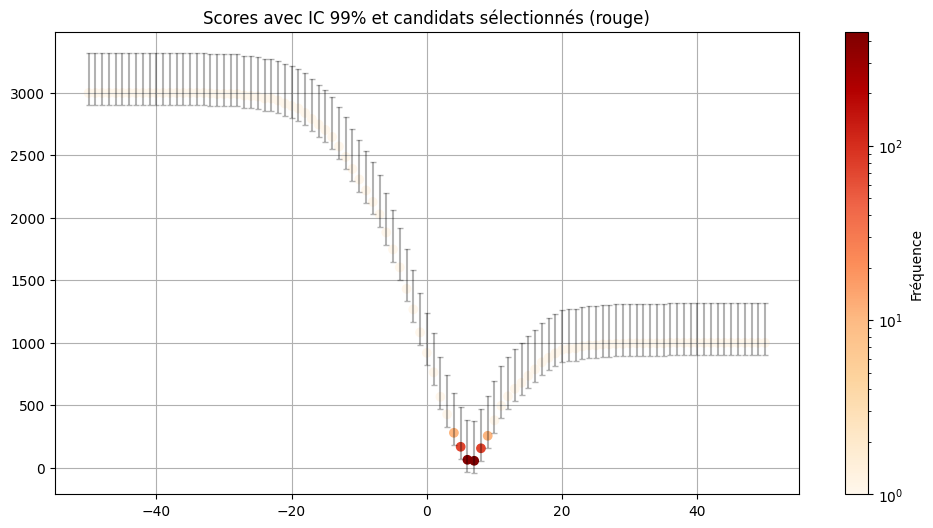

Counter({7.0: 449, 6.0: 380, 8.0: 75, 5.0: 71, 9.0: 11, 4.0: 11, 11.0: 1, 2.0: 1, 3.0: 1})
Le nombre de candidats différent sélectionnés est : 9


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r
import opendp.prelude as dp
from matplotlib.colors import LogNorm
from matplotlib import cm, colors as mcolors
dp.enable_features("contrib")
np.random.seed(123)

n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
alpha = 0.75
epsilon = 0.1

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()

scale = dp.binary_search_param(
    lambda s: space
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    >> dp.m.then_report_noisy_max_gumbel(scale=s, optimize="min")
    >> (lambda i: candidats[i]),
    d_in=1, d_out=epsilon)

# Avec ceci big trouble
quantile = space >> dp.m.then_private_quantile(
    candidates=candidats,
    alpha=alpha,
    scale=scale
)

# Ici tout va bien :)
quantile = (
    space
    # 1. transformation: calcul du score associé à chaque candidat
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    # 2. measurement: tire l'index score le plus petit après ajout du bruit
    >> dp.m.then_report_noisy_max_gumbel(scale=scale, optimize="min")
    # 3. postprocessor: renvoie le candidat à partir de l'index
    >> (lambda i: candidats[i])
)

# Simulation
N = 1000
list_values = [quantile(data) for _ in range(N)]

quantile_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidats, 
    alpha=alpha)

scores = quantile_scores(data)

# IC à 99 %
low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * quantile_scores.map(d_in=1) / epsilon)
lower = scores + low_q
upper = scores + high_q

counter = Counter(list_values)
counts = [counter.get(c, 0) for c in candidats]

norm = LogNorm(vmin=1, vmax=max(counts))  # attention : vmin > 0
cmap = cm.OrRd  # plus doux que Reds
colors = [mcolors.to_hex(cmap(norm(max(counter.get(c, 1), 1)))) for c in candidats]

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(candidats, scores, c=colors)
ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
            fmt='none', capsize=2, color='black', alpha=0.3)
ax.set_title("Scores avec IC 99% et candidats sélectionnés (rouge)")
ax.grid(True)

# Colorbar attachée explicitement à l'axe
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
plt.colorbar(sm, ax=ax, label="Fréquence")

plt.show()

print(f"{counter}")
print("Le nombre de candidats différent sélectionnés est :", len(set(list_values)))

# Etude cas non réel

[ 0.  3.  6. 10.]


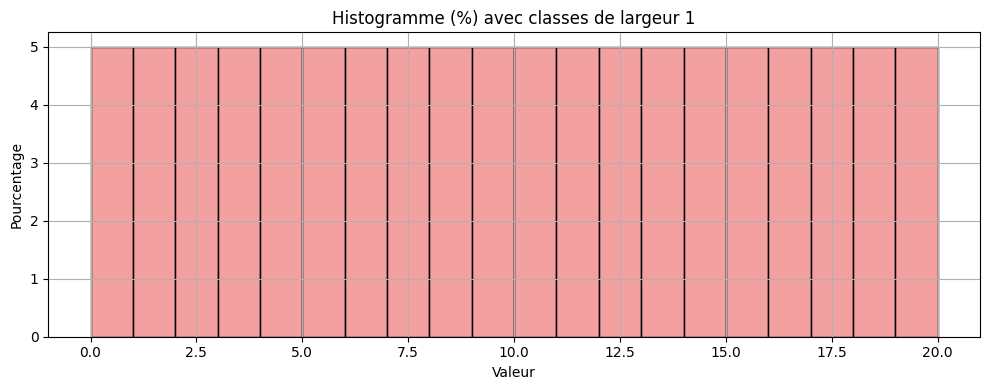

In [107]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = np.linspace(0, 20, 100)

list_alpha = [0, 0.15, 0.3, 0.5]

valeurs = np.percentile(data, [100 * alpha for alpha in list_alpha])

print(valeurs)

# Définir les bornes de chaque intervalle d'1 unité
min_val = int(np.floor(data.min()))
max_val = int(np.ceil(data.max()))
bins = np.arange(min_val, max_val + 1, 1)  # pas de 1 unité

# Tracé
plt.figure(figsize=(10, 4))
sns.histplot(data, stat="percent", bins=bins, color='lightcoral', edgecolor='black')
plt.title("Histogramme (%) avec classes de largeur 1")
plt.xlabel("Valeur")
plt.ylabel("Pourcentage")
plt.grid(True)
plt.tight_layout()
plt.show()


# Cas n = 100

Sensibilité estimé : 10000
Sensibilité estimé : 9000
Sensibilité estimé : 7500
Sensibilité estimé : 5000


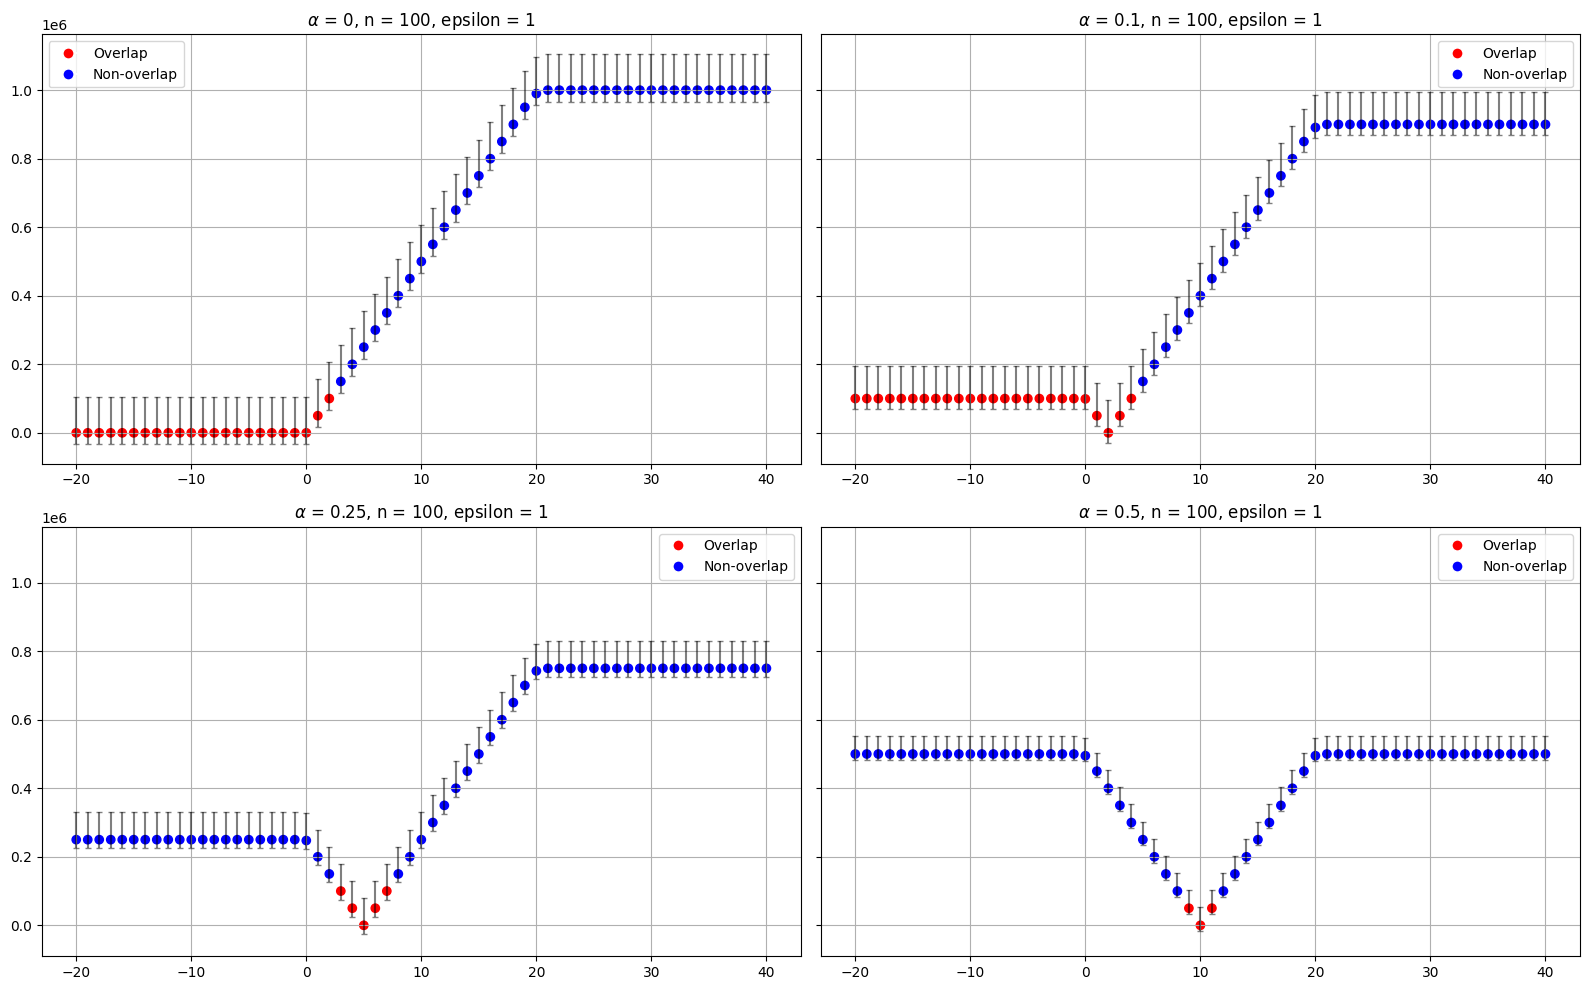

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 100
data = np.linspace(0, 20, n)
candidats = np.linspace(-20, 40, 61).tolist()
list_alpha = [0, 0.1, 0.25, 0.5]
epsilon = 1

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

# Cas n = 1000

Sensibilité estimé : 10000
Sensibilité estimé : 9000
Sensibilité estimé : 7500
Sensibilité estimé : 5000


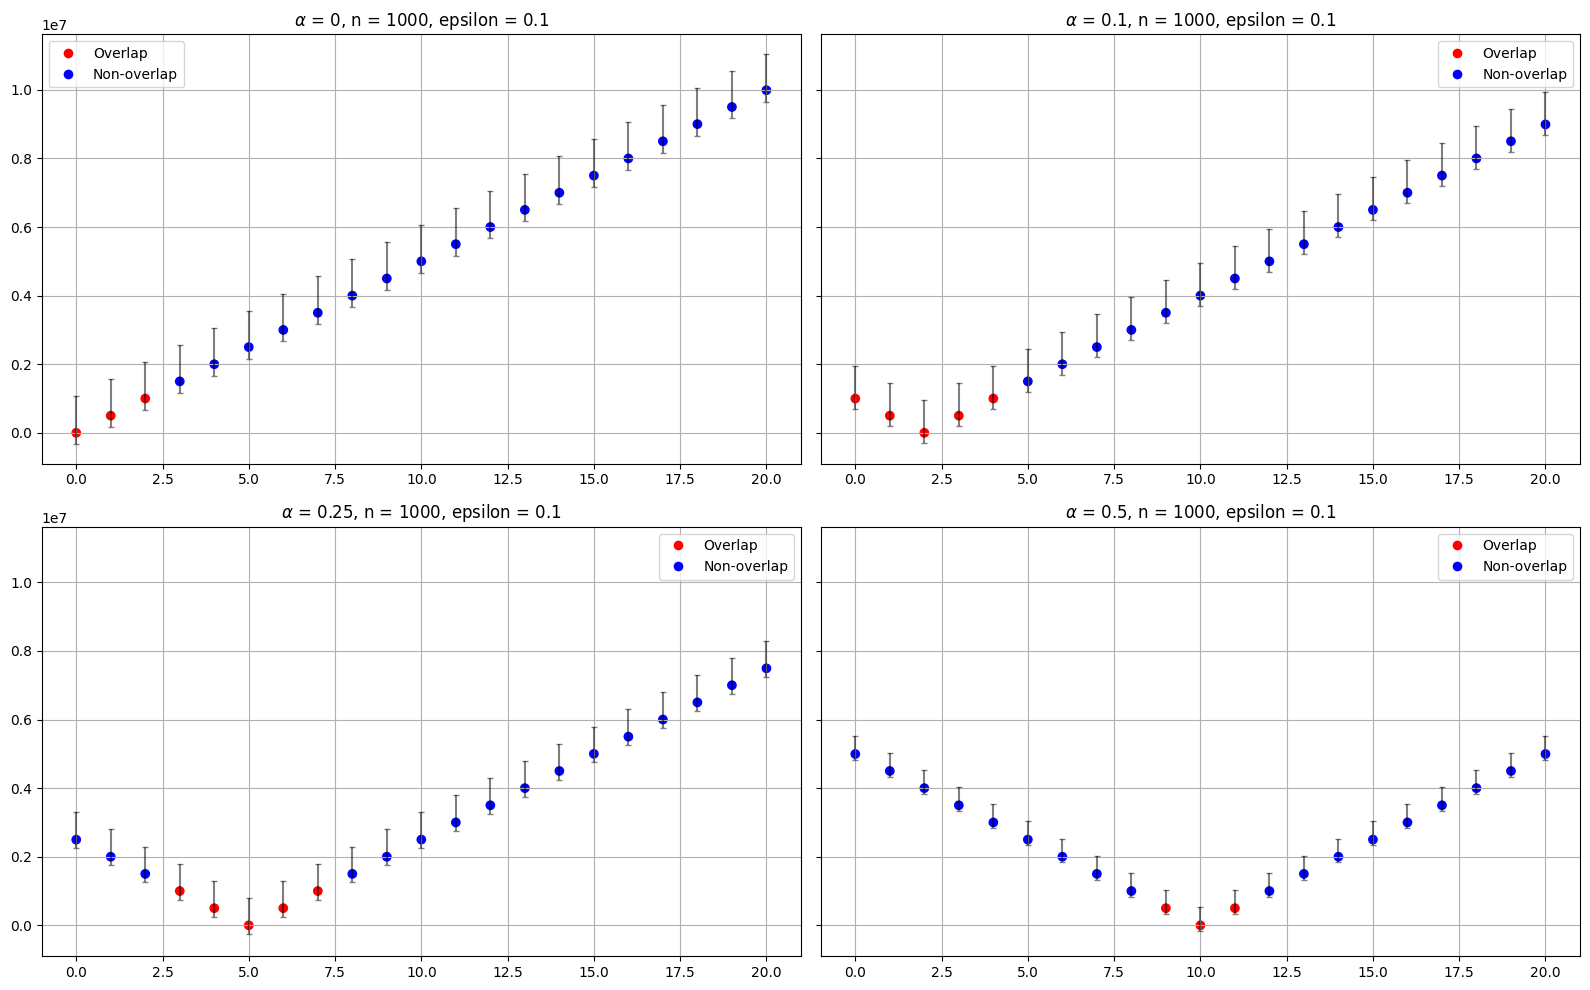

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 1000
data = np.linspace(0, 20, n)
candidats = np.linspace(0, 20, 21).tolist()
list_alpha = [0, 0.1, 0.25, 0.5]
epsilon = 0.1

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])
plt.tight_layout()
plt.show()

# Etude d'un cas particulier

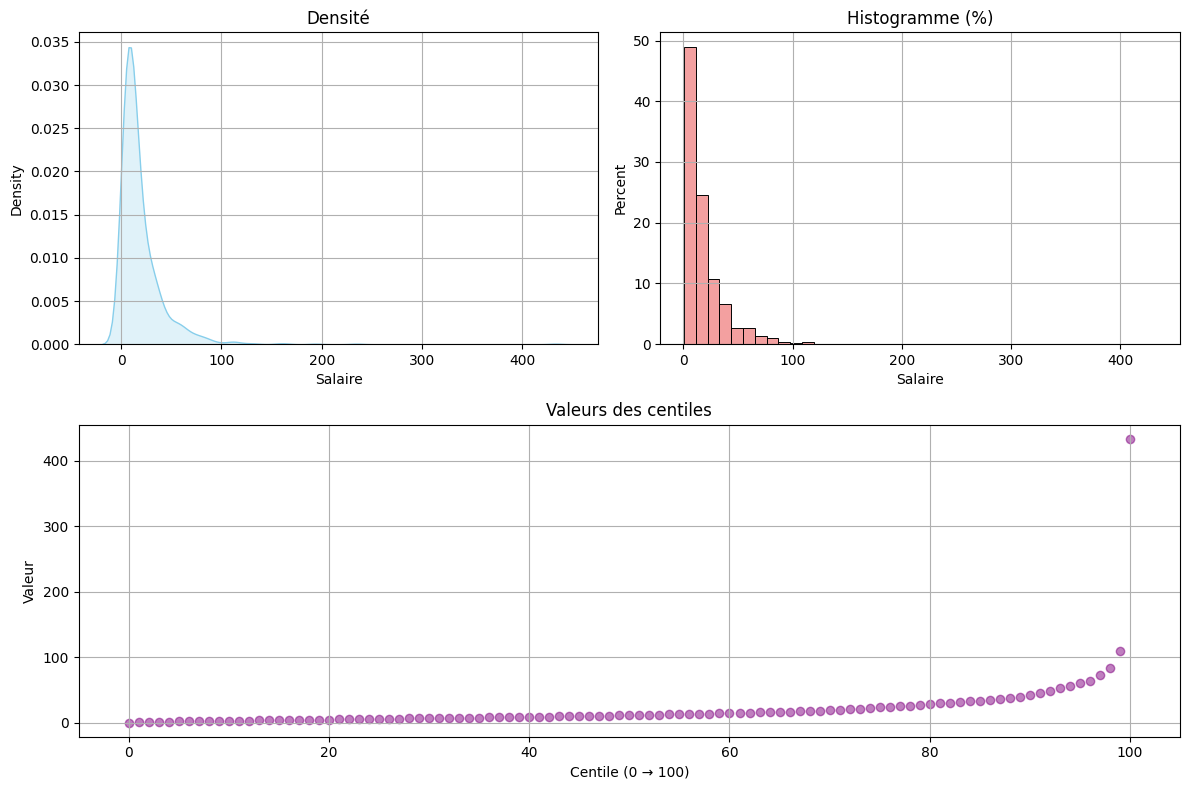

,data
count,1000.000000
mean,19.239277
std,25.433106
min,0.481401
25%,6.143816
50%,11.690963
75%,23.780507
max,433.364519


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(123) 

data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 lignes, 2 colonnes

# Graphique en haut à gauche
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data, fill=True, color='skyblue', ax=ax1)
ax1.set_title("Densité")
ax1.set_xlabel("Salaire")
ax1.grid(True)

# Graphique en haut à droite
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data, stat="percent", bins=40, color='lightcoral', ax=ax2)
ax2.set_title("Histogramme (%)")
ax2.set_xlabel("Salaire")
ax2.grid(True)

# Graphique en bas sur toute la largeur
ax3 = fig.add_subplot(gs[1, :])

# Calcul des centiles (0 à 100)
centiles = np.arange(101)
valeurs = np.percentile(data, centiles)

candidats = np.linspace(0, 400, 101).tolist()
ax3.scatter(centiles, valeurs, color="purple", alpha=0.5)
ax3.set_title("Valeurs des centiles")
ax3.set_xlabel("Centile (0 → 100)")
ax3.set_ylabel("Valeur")
ax3.grid(True)

plt.tight_layout()
plt.show()

df = pd.DataFrame({"data": data})
df.describe()

## Focus sur la première moitié des données

[ 0.48140084  5.06321754  9.26875492 11.6909632 ]


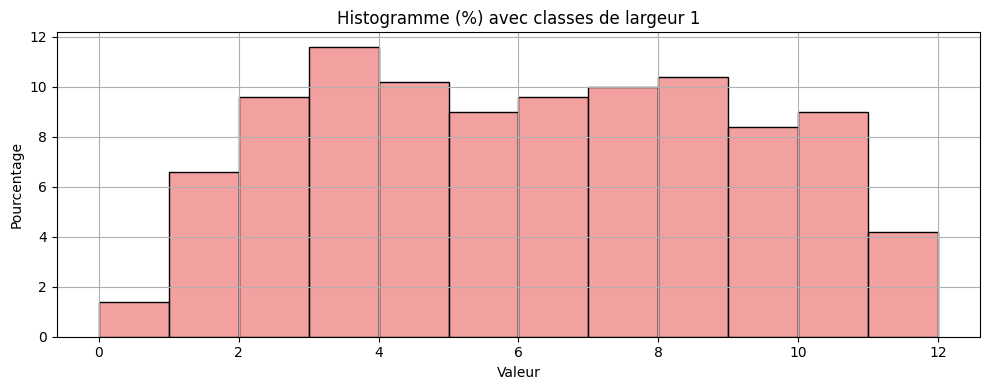

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Données
np.random.seed(123)
data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
list_alpha = [0, 0.2, 0.4, 0.5]

valeurs = np.percentile(data, [100 * alpha for alpha in list_alpha])

print(valeurs)

data_filtre = data[data <= np.median(data)]

# Définir les bornes de chaque intervalle d'1 unité
min_val = int(np.floor(data_filtre.min()))
max_val = int(np.ceil(data_filtre.max()))
bins = np.arange(min_val, max_val + 1, 1)  # pas de 1 unité

# Tracé
plt.figure(figsize=(10, 4))
sns.histplot(data_filtre, stat="percent", bins=bins, color='lightcoral', edgecolor='black')
plt.title("Histogramme (%) avec classes de largeur 1")
plt.xlabel("Valeur")
plt.ylabel("Pourcentage")
plt.grid(True)
plt.tight_layout()
plt.show()


## Focus données intégrales

[ 23.78050672  28.54256873  42.74533522 110.0301605 ]


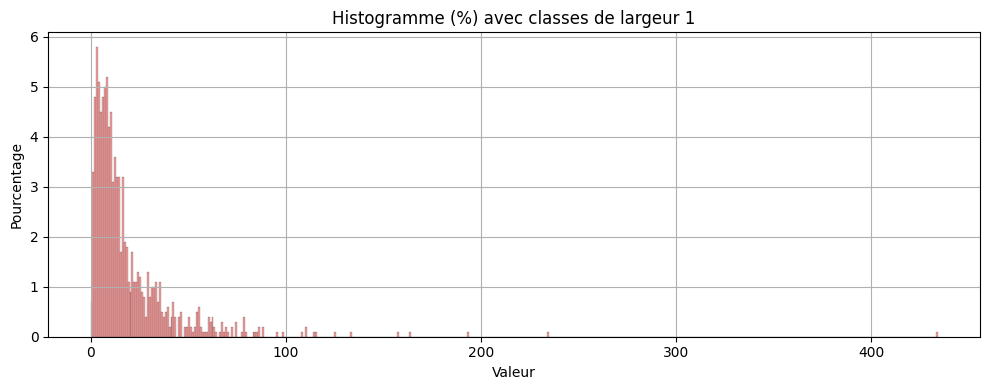

In [135]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Données
np.random.seed(123)
data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
list_alpha = [0.75, 0.8, 0.9, 0.99]

valeurs = np.percentile(data, [100 * alpha for alpha in list_alpha])

print(valeurs)

# Définir les bornes de chaque intervalle d'1 unité
min_val = int(np.floor(data.min()))
max_val = int(np.ceil(data.max()))
bins = np.arange(min_val, max_val + 1, 1)  # pas de 1 unité

# Tracé
plt.figure(figsize=(10, 4))
sns.histplot(data, stat="percent", bins=bins, color='lightcoral', edgecolor='black')
plt.title("Histogramme (%) avec classes de largeur 1")
plt.xlabel("Valeur")
plt.ylabel("Pourcentage")
plt.grid(True)
plt.tight_layout()
plt.show()


Sensibilité estimé : 7500
Sensibilité estimé : 8000
Sensibilité estimé : 9000
Sensibilité estimé : 9900


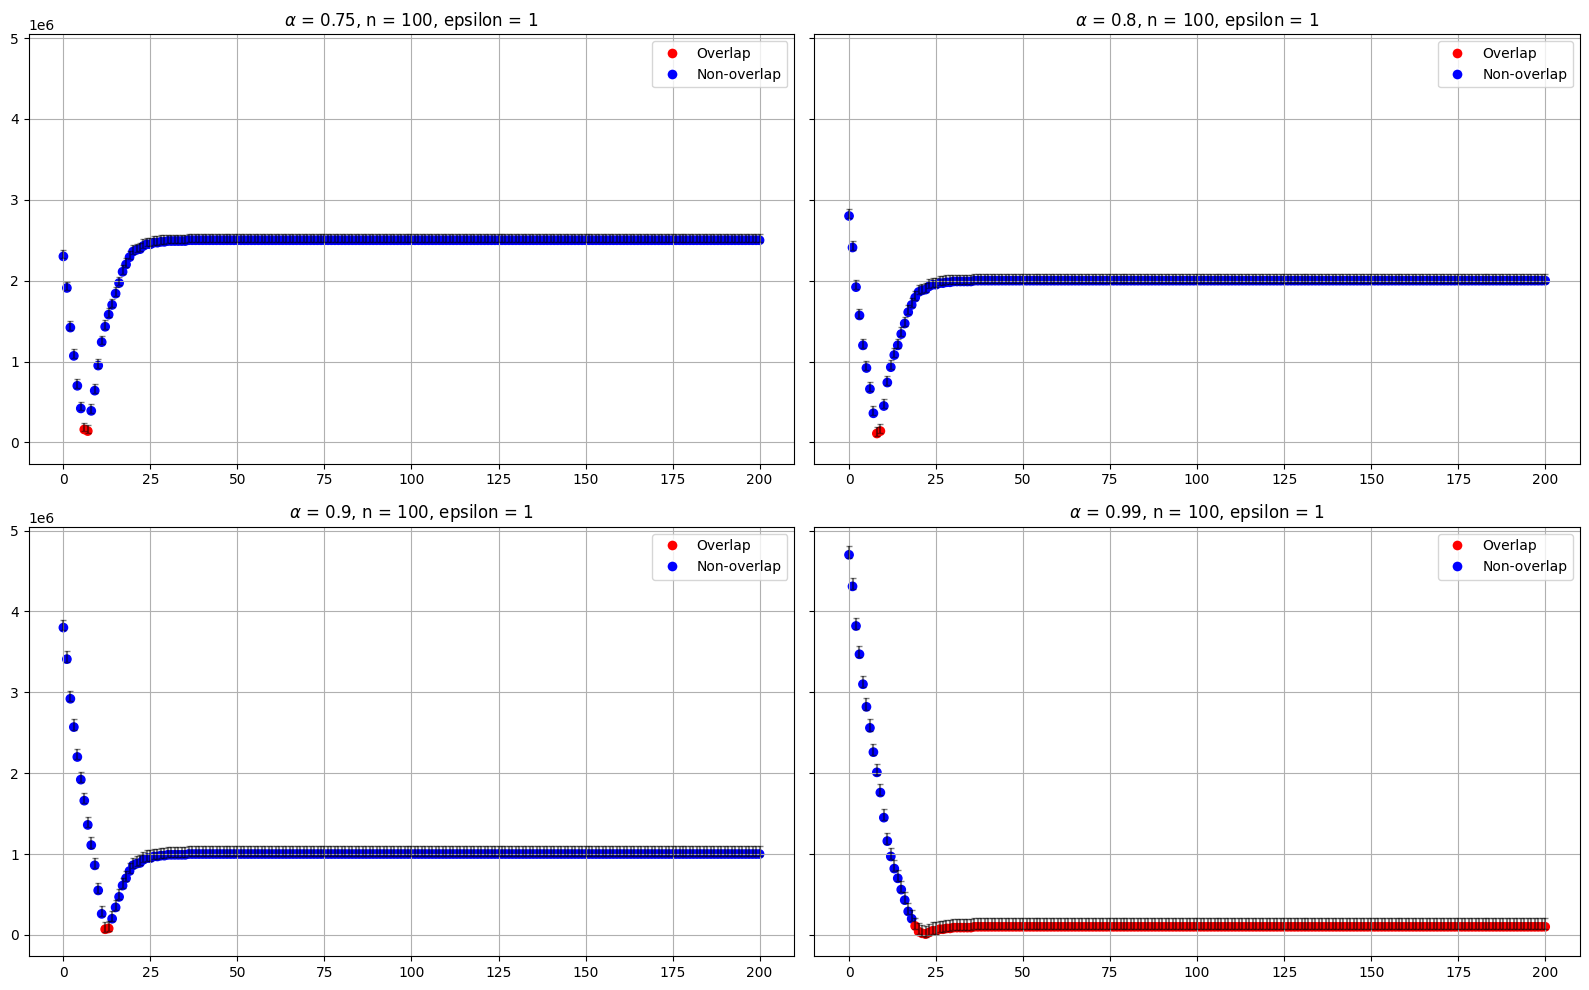

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
candidats = np.linspace(0, 200, 201).tolist()
list_alpha = [0.75, 0.8, 0.9, 0.99]
epsilon = 1

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

Observations pour les min et max, s'il dépasse le vrai min ou le vrai max alors ils ont autant de chances d'êtres tirés que la vrai valeur donc il faut faire attention de ce coté la.
Si on ajoute des candidats qui étaient déjà pas compris dans la zone en rouge, pas de problème.
Il faut que la taille du dataset soit inversement proportionnelle à epsilon
Dans le cas de données uniformément réparties, multiplier n par 10 nécessite de diviser n par 10 pour retomber sur la meme courbe